In [10]:
import numpy as np
import cupy as cp
import warnings
import os

use_gpu = True


from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.utility import get_overlap, get_mismatch, get_separatrix, get_fundamental_frequencies
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.utils.constants import *
from few.utils.baseclasses import SchwarzschildEccentric, ParallelModuleBase
from few.waveform import AAKWaveformBase
from few.summation.aakwave import AAKSummation

import matplotlib.pyplot as plt

from few.utils.utility import get_p_at_t

import time
import warnings

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e8),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = EMRIInspiral(func="SchwarzEccGasSubFlux")  # added a new class to ode_base to include the gas torque effects in subsonic motion called SchwarzEccGasSubFlux#

In [11]:
#supporting functions defined outside
#defining Sensitivity curve (for 1 year) 
def sensitivity(f):
    
    #Defining supporting functions
    L = 2.5e9 #m
    fstar = 19.09e-3 #Hz
    
    P_OMS = (1.5e-11**2)*(1+(2e-3/f)**4) #Hz-1
    P_acc = (3e-15**2)*(1+(0.4e-3/f)**2)*(1+(f/8e-3)**4) #Hz-1
    
    #S_c changes depending on signal duration (Equation 14 in 1803.01944)
    #for 1 year
    alpha = 0.171
    beta = 292
    kappa = 1020
    gamma = 1680
    fk = 0.00215
    #log10_Sc = (np.log10(9)-45) -7/3*np.log10(f) -(f*alpha + beta*f*np.sin(kappa*f))*np.log10(np.e) + np.log10(1 + np.tanh(gamma*(fk-f))) #Hz-1 
    
    A=9e-45
    Sc = A*f**(-7/3)*np.exp(-f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(fk-f)))
    
    return (10/(3*L**2))*(P_OMS+4*(P_acc)/((2*np.pi*f)**4))*(1 + 6*f**2/(10*fstar**2))+Sc
    
#Defining the inner product (this runs on the GPU)
from cupy.fft import rfft, rfftfreq
import cupy as cp 

def inner_product(a,b,dt=10):
    #Taking the FFTs of a and b
    n = max((len(a),len(b)))
    f = rfftfreq(n)/dt
    df = 1/(n*dt)
    atilde_real = rfft(a.real*dt, n=n)[1:]
    btilde_real = rfft(b.real*dt, n=n)[1:]

    plus_prod = cp.conj(atilde_real)@(btilde_real/sensitivity(f[1:]))

    atilde_imag = rfft(a.imag*dt, n=n)[1:]
    btilde_imag = rfft(b.imag*dt, n=n)[1:]

    cross_prod = cp.conj(atilde_imag)@(btilde_imag/sensitivity(f[1:]))
    return 4*df*cp.real(plus_prod+cross_prod)

#defining the function for plotting the covariance ellipses

from matplotlib.patches import Ellipse
from matplotlib import transforms

def cov_ellipse(mean, cov, ax, n_std=1.0, edgecolor='blue',facecolor='none',lw=5, **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    #print(pearson)
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        edgecolor=edgecolor,
        facecolor=facecolor,
        lw = lw,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def normal(mean, var, x):
    return np.exp(-(mean-x)**2/var/2)

In [36]:
#=============================================================

class StableEMRIFisher:
    
    def __init__(self, M, mu, a, p0, e0, Y0, Sigma0, SigmaPower, h0, dist, qS, phiS, qK, phiK,\
                 Phi_phi0, Phi_theta0, Phi_r0, dt = 10, T = 1, param_names=[],\
                 deltas=None, der_order=2, Ndelta=8, err = 5e-12, DENSE_STEPPING=0, CovMat=False, CovEllipse=False, filename='', suffix=None):
        
        #Basic Consistency Check
        if deltas != None and len(deltas) != 14+3-4: #+3 accretion, -4 for a, Y0, qK, and phiK
            print('Length of deltas array should be equal to the no. of 5PNAAK parameters.\n\
                   Assuming deltas = None.')
            deltas = None
        
        #initializing param_names list
        if len(param_names) == 0:
            self.param_names = ['M','mu','p0','e0','dist','qS','phiS','Phi_phi0', 'Phi_theta0','Phi_r0','Sigma0','SigmaPower','h0']
            
        elif len(param_names) != 14+3-4:
            print('Warning! Lenght of param_names must be equal to the no. of 5PNAAK parameters.\n\
                   Assuming default order of parameters.')
            
            self.param_names = ['M','mu','p0','e0','dist','qS','phiS','Phi_phi0', 'Phi_theta0','Phi_r0','Sigma0','SigmaPower','h0']

            
            
        elif len(param_names) == 14+3-2:
            self.param_names = param_names
        
        #initializing FEW
        #defining model parameters

        use_gpu = True
        
        self.DENSE_STEPPING = DENSE_STEPPING
        self.err = err
        
        inspiral_kwargs = {
                "DENSE_STEPPING": self.DENSE_STEPPING,
                "max_init_len": int(1e8),
                "err": self.err,
                "func":"SchwarzEccGasSubFlux",
            }
            
        # keyword arguments for summation generator (AAKSummation)
        sum_kwargs = {
            "use_gpu": use_gpu,  # GPU is availabel for this type of summation
            "pad_output": False,
        }

        self.wave_generator = AAKWaveformBase(
                                EMRIInspiral,
                                AAKSummation,
                                inspiral_kwargs=inspiral_kwargs, 
                                sum_kwargs=sum_kwargs, 
                                use_gpu=use_gpu)

        
        #initializing parameters
        self.M = M
        self.mu = mu
        self.a = a
        self.p0 = p0
        self.e0 = e0
        self.Y0 = Y0
        
        self.Sigma0 = Sigma0
        self.SigmaPower = SigmaPower
        self.h0 = h0
        
        self.dist = dist
        self.qS = qS
        self.phiS = phiS
        self.qK = qK
        self.phiK = phiK
        self.Phi_phi0 = Phi_phi0
        self.Phi_theta0 = Phi_theta0
        self.Phi_r0 = Phi_r0
        self.dt = dt
        self.T = T
        self.order = der_order
        self.Ndelta = Ndelta
        
        #initializing param dictionary
        self.param = {'M':M,\
                      'mu':mu,\
                      'p0':p0,\
                      'e0':e0,\
                      'dist':dist,\
                      'qS':qS,\
                      'phiS':phiS,\
                      'Phi_phi0':Phi_phi0,\
                      'Phi_theta0':Phi_theta0,\
                      'Phi_r0':Phi_r0,\
                      'Sigma0':Sigma0,\
                      'SigmaPower':SigmaPower,\
                      'h0':h0,}
        
        #initializing deltas
        self.deltas = deltas #Use deltas == None as a Flag
        
        #initializing other Flags:
        self.CovMat = CovMat
        self.CovEllipse = CovEllipse
        self.filename = filename
        self.suffix = suffix
         
    def __call__(self):
        
        #generating the waveform
        self.waveform = self.wave_generator(self.M, self.mu, self.a, self.p0, self.e0, self.Y0, \
                                  self.dist, self.qS, self.phiS, self.qK, self.phiK, \
                                  self.Sigma0,self.SigmaPower,self.h0, \
                                  Phi_phi0=self.Phi_phi0, Phi_theta0=self.Phi_theta0, Phi_r0=self.Phi_r0, mich=True, dt=self.dt, T=self.T)
        
        rho = np.sqrt(inner_product(self.waveform,self.waveform,dt=self.dt)).real
        print('Waveform Generated. SNR: ', rho)
        
        #making parent folder
        if not os.path.exists(self.filename):
            os.makedirs(self.filename)
        
        #Performing tasks chronologically
        
        #1. If deltas not provided, calculating the stable deltas
        if self.deltas == None:
            self.Fisher_Stability() #generates self.deltas
        
        #2. Given the deltas, we calculate the Fisher Matrix
        Fisher = self.FisherCalc()
        
        #3. If demanded, calculate the covariance Matrix
        if self.CovMat:
            covariance = np.linalg.inv(Fisher)
        else: 
            covariance = []
            
        if self.CovEllipse:
            covariance = np.linalg.inv(Fisher)
            self.CovEllipsePlot(covariance)
            
        return Fisher, covariance
    
    #Now, we define the functions being used by the class
    
    #defining the derivative function
    def derivative(self, i, delta):
        
        #if calculating partial derivatives over extrinsic param set, sparse trajectories can be used.
        if self.param_names[i] == 'dist' or self.param_names[i] == 'qS' or self.param_names[i] == 'phiS' or self.param_names[i] == 'qK' or self.param_names[i] == 'phiK':
            inspiral_kwargs = {
                "DENSE_STEPPING": 0,
                "max_init_len": int(1e8),
                "err":1e-10, #default
                "func":"SchwarzEccGasSubFlux"
            }

            # keyword arguments for summation generator (AAKSummation)
            sum_kwargs = {
                "use_gpu": True,
                "pad_output": False,
            }

            self.wave_generator = AAKWaveformBase(
                                EMRIInspiral,
                                AAKSummation,
                                inspiral_kwargs=inspiral_kwargs, 
                                sum_kwargs=sum_kwargs, 
                                use_gpu=use_gpu)

        else:
            inspiral_kwargs = {
                "DENSE_STEPPING": self.DENSE_STEPPING,
                "max_init_len": int(1e8),
                "err": self.err,
                "func":"SchwarzEccGasSubFlux"
            }

            # keyword arguments for summation generator (AAKSummation)
            sum_kwargs = {
                "use_gpu": True,
                "pad_output": False,
            }

            self.wave_generator = AAKWaveformBase(
                                EMRIInspiral,
                                AAKSummation,
                                inspiral_kwargs=inspiral_kwargs, 
                                sum_kwargs=sum_kwargs, 
                                use_gpu=use_gpu)

            
        
        #modifying the given parameter
        temp = self.param.copy()

        temp[self.param_names[i]] += delta
        print(self.param_names[i],' = ', temp[self.param_names[i]])

        waveform_plus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )

        temp = self.param.copy()

        temp[self.param_names[i]] -= delta

        waveform_minus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )
        
        if self.order == 2:
            #padding waveforms with zeros in the end in case of early plunge than the original waveform
            if len(waveform_plus) < len(self.waveform):
                waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))

            elif len(waveform_plus) > len(self.waveform):
                waveform_plus = waveform_plus[:len(self.waveform)]
                
            if len(waveform_minus) < len(self.waveform):
                waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))

            elif len(waveform_minus) > len(self.waveform):
                waveform_minus = waveform_minus[:len(self.waveform)]

             
            #2nd order finite difference differentiation
            derivative = (waveform_plus - waveform_minus)/(2*delta)
            
            del waveform_plus
            del waveform_minus
            
            return derivative
        
        temp = self.param.copy()

        temp[self.param_names[i]] += 2*delta

        waveform_2plus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )
        
        temp = self.param.copy()

        temp[self.param_names[i]] -= 2*delta

        waveform_2minus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )

        if self.order == 4:
            #padding waveforms with zeros in the end in case of early plunge than the original waveform
            if len(waveform_plus) < len(self.waveform):
                waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))

            elif len(waveform_plus) > len(self.waveform):
                waveform_plus = waveform_plus[:len(self.waveform)]
                
            if len(waveform_minus) < len(self.waveform):
                waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))

            elif len(waveform_minus) > len(self.waveform):
                waveform_minus = waveform_minus[:len(self.waveform)]
                
            if len(waveform_2plus) < len(self.waveform):
                waveform_2plus = cp.concatenate((waveform_2plus,cp.zeros(len(self.waveform)-len(waveform_2plus), dtype=cp.complex64)))

            elif len(waveform_2plus) > len(self.waveform):
                waveform_2plus = waveform_2plus[:len(self.waveform)]

            if len(waveform_2minus) < len(self.waveform):
                waveform_2minus = cp.concatenate((waveform_2minus,cp.zeros(len(self.waveform)-len(waveform_2minus), dtype=cp.complex64)))

            elif len(waveform_2minus) > len(self.waveform):
                waveform_2minus = waveform_2minus[:len(self.waveform)]
                
            #4th order finite difference differentiation
            derivative = (1/12*waveform_2minus - 2/3*waveform_minus + 2/3*waveform_plus -1/12*waveform_2plus)/(delta)
                
            del waveform_plus
            del waveform_minus
            del waveform_2plus
            del waveform_2minus
            
            return derivative
        
        temp = self.param.copy()

        temp[self.param_names[i]] += 3*delta

        waveform_3plus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )
        
        temp = self.param.copy()

        temp[self.param_names[i]] -= 3*delta

        waveform_3minus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )
        
        if self.order == 6:
            #padding waveforms with zeros in the end in case of early plunge than the original waveform
            if len(waveform_plus) < len(self.waveform):
                waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))

            elif len(waveform_plus) > len(self.waveform):
                waveform_plus = waveform_plus[:len(self.waveform)]
                
            if len(waveform_minus) < len(self.waveform):
                waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))

            elif len(waveform_minus) > len(self.waveform):
                waveform_minus = waveform_minus[:len(self.waveform)]
                
            if len(waveform_2plus) < len(self.waveform):
                waveform_2plus = cp.concatenate((waveform_2plus,cp.zeros(len(self.waveform)-len(waveform_2plus), dtype=cp.complex64)))

            elif len(waveform_2plus) > len(self.waveform):
                waveform_2plus = waveform_2plus[:len(self.waveform)]

            if len(waveform_2minus) < len(self.waveform):
                waveform_2minus = cp.concatenate((waveform_2minus,cp.zeros(len(self.waveform)-len(waveform_2minus), dtype=cp.complex64)))

            elif len(waveform_2minus) > len(self.waveform):
                waveform_2minus = waveform_2minus[:len(self.waveform)]
                
            if len(waveform_3plus) < len(self.waveform):
                waveform_3plus = cp.concatenate((waveform_3plus,cp.zeros(len(self.waveform)-len(waveform_3plus), dtype=cp.complex64)))

            elif len(waveform_3plus) > len(self.waveform):
                waveform_3plus = waveform_3plus[:len(self.waveform)]
                
            if len(waveform_3minus) < len(self.waveform):
                waveform_3minus = cp.concatenate((waveform_3minus,cp.zeros(len(self.waveform)-len(waveform_3minus), dtype=cp.complex64)))

            elif len(waveform_3minus) > len(self.waveform):
                waveform_3minus = waveform_3minus[:len(self.waveform)]

                
            #4th order finite difference differentiation
            derivative = (-1/60*waveform_3minus+3/20*waveform_2minus - 3/4*waveform_minus + 3/4*waveform_plus - 3/20*waveform_2plus +1/60*waveform_3plus)/(delta)
                
            del waveform_plus
            del waveform_minus
            del waveform_2plus
            del waveform_2minus
            del waveform_3plus
            del waveform_3minus
            
            return derivative
        
        temp = self.param.copy()

        temp[self.param_names[i]] += 4*delta

        waveform_4plus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )
        
        temp = self.param.copy()

        temp[self.param_names[i]] -= 4*delta

        waveform_4minus = self.wave_generator(temp['M'],\
                    temp['mu'],\
                    a,\
                    temp['p0'],\
                    temp['e0'],\
                    Y0,\
                    temp['dist'],\
                    temp['qS'],\
                    temp['phiS'],\
                    qK,\
                    phiK,\
                    temp['Sigma0'],\
                    temp['SigmaPower'],\
                    temp['h0'],\
                    Phi_phi0= temp['Phi_phi0'],\
                    Phi_theta0=temp['Phi_theta0'],\
                    Phi_r0=temp['Phi_r0'],\
                    mich=True,\
                    T = self.T,\
                    dt = self.dt
                    )


        #padding waveforms with zeros in the end in case of early plunge than the original waveform
        if len(waveform_plus) < len(self.waveform):
            waveform_plus = cp.concatenate((waveform_plus,cp.zeros(len(self.waveform)-len(waveform_plus), dtype=cp.complex64)))

        elif len(waveform_plus) > len(self.waveform):
            waveform_plus = waveform_plus[:len(self.waveform)]

        if len(waveform_2plus) < len(self.waveform):
            waveform_2plus = cp.concatenate((waveform_2plus,cp.zeros(len(self.waveform)-len(waveform_2plus), dtype=cp.complex64)))

        elif len(waveform_2plus) > len(self.waveform):
            waveform_2plus = waveform_2plus[:len(self.waveform)]

        if len(waveform_3plus) < len(self.waveform):
            waveform_3plus = cp.concatenate((waveform_3plus,cp.zeros(len(self.waveform)-len(waveform_3plus), dtype=cp.complex64)))

        elif len(waveform_3plus) > len(self.waveform):
            waveform_3plus = waveform_3plus[:len(self.waveform)]

        if len(waveform_4plus) < len(self.waveform):
            waveform_4plus = cp.concatenate((waveform_4plus,cp.zeros(len(self.waveform)-len(waveform_4plus), dtype=cp.complex64)))

        elif len(waveform_4plus) > len(self.waveform):
            waveform_4plus = waveform_4plus[:len(self.waveform)]

        if len(waveform_minus) < len(self.waveform):
            waveform_minus = cp.concatenate((waveform_minus,cp.zeros(len(self.waveform)-len(waveform_minus), dtype=cp.complex64)))

        elif len(waveform_minus) > len(self.waveform):
            waveform_minus = waveform_minus[:len(self.waveform)]

        if len(waveform_2minus) < len(self.waveform):
            waveform_2minus = cp.concatenate((waveform_2minus,cp.zeros(len(self.waveform)-len(waveform_2minus), dtype=cp.complex64)))

        elif len(waveform_2minus) > len(self.waveform):
            waveform_2minus = waveform_2minus[:len(self.waveform)]

        if len(waveform_3minus) < len(self.waveform):
            waveform_3minus = cp.concatenate((waveform_3minus,cp.zeros(len(self.waveform)-len(waveform_3minus), dtype=cp.complex64)))

        elif len(waveform_3minus) > len(self.waveform):
            waveform_3minus = waveform_3minus[:len(self.waveform)]

        if len(waveform_4minus) < len(self.waveform):
            waveform_4minus = cp.concatenate((waveform_4minus,cp.zeros(len(self.waveform)-len(waveform_4minus), dtype=cp.complex64)))

        elif len(waveform_4minus) > len(self.waveform):
            waveform_4minus = waveform_4minus[:len(self.waveform)]

        #8th order finite difference differentiation
        derivative = (waveform_4minus/280 - waveform_3minus*4/105 + waveform_2minus/5 - waveform_minus*4/5 \
                    - waveform_4plus/280 + waveform_3plus*4/105 - waveform_2plus/5 + waveform_plus*4/5)/(delta)

        del waveform_plus
        del waveform_minus
        del waveform_2plus
        del waveform_2minus
        del waveform_3plus
        del waveform_3minus
        del waveform_4plus
        del waveform_4minus
        
        return derivative
    
    
    #defining Fisher_Stability function, generates self.deltas
    def Fisher_Stability(self):
        print('calculating stable deltas...')
        Ndelta = self.Ndelta
        
        deltas = {}
        stability_flag = True
        unstable_params = []

        for i in range(len(self.param_names)):
            #custom delta_inits for different parameters
            if self.param[self.param_names[i]] == 0.0:
                delta_init = np.geomspace(1e-8,1e-16,Ndelta)

            elif self.param_names[i] == 'M' or self.param_names[i] == 'mu' or self.param_names[i] == 'a' or self.param_names[i] == 'p0' or self.param_names[i] == 'e0' or self.param_names[i] == 'Y0':
                delta_init = np.geomspace(1e-4*self.param[self.param_names[i]],1e-10*self.param[self.param_names[i]],Ndelta)
                
            else:
                delta_init = np.geomspace(1e-1*self.param[self.param_names[i]],1e-10*self.param[self.param_names[i]],Ndelta)

            #sanity check:
            if self.param_names[i] == 'a' and self.param[self.param_names[i]] >= 1.:
                self.param_names[i] = 0.999
            if self.param_names[i] == 'p0' and self.param[self.param_names[i]] <= 5:
                self.param_names[i] = 5.0001
            if self.param_names[i] == 'e0' and self.param[self.param_names[i]] <= 0.:
                self.param_names[i] = 1e-6
            
            Gamma = []
            orderofmag = []

            for k in range(Ndelta):
                del_k = self.derivative(i, delta_init[k])

                #Calculating the Fisher Elements
                Gammai = inner_product(del_k,del_k,dt=self.dt)
                print(Gammai)
                Gamma.append(Gammai)
                relerr_flag = False
                #if k >= 1:
                #    relerr = np.abs(Gamma[k]-Gamma[k-1])/Gamma[k]
                #    print(relerr)
                #    orderofmag.append(np.floor(np.log10(relerr)))
                #    print(orderofmag)
                #    if k >= 2:
                #        if orderofmag[-1] > orderofmag[-2]:
                #            deltas[self.param_names[i]] = np.float64(delta_init[k-1])
                #            relerr_flag = True
                #            break
            
            if relerr_flag == False:
                Gamma = cp.asnumpy(cp.array(Gamma))
                relerr = np.abs(Gamma[1:] - Gamma[:-1])/Gamma[1:]
                print(relerr)
                relerr_min_i, = np.where(np.isclose(relerr, np.min(relerr),rtol=1e-1*np.min(relerr),atol=1e-1*np.min(relerr)))
                if len(relerr_min_i) > 1:
                    relerr_min_i = relerr_min_i[-1]
                print(relerr_min_i)
                
                if np.min(relerr) >= 0.01:
                    stability_flag = False
                    unstable_params.append(self.param_names[i])

                deltas[self.param_names[i]] = np.float64(delta_init[relerr_min_i])
            
            #plt.plot(delta_init,Gamma,'ro-')
            #plt.xscale('log')
            #plt.yscale('log')
            #plt.show()
            
        print('stable deltas: ', deltas)
        
        if stability_flag == False:
            warnings.warn(f'minimum relative error is greater than 1% for {unstable_params}. Fisher may be unstable!')
            
            
        self.deltas = deltas
        if self.filename != '':
            if self.suffix != None:
                with open(f"{self.filename}/stable_deltas_{self.suffix}.txt", "w", newline="") as file:
                    file.write(str(deltas))
            else:
                with open(f"{self.filename}/stable_deltas.txt", "w", newline="") as file:
                    file.write(str(deltas))
        
    #defining FisherCalc function, returns Fisher
    def FisherCalc(self):
        print('calculating Fisher matrix...')
        Fisher = np.zeros((len(self.param_names),len(self.param_names)),dtype = np.float64)

        dtv = cp.zeros((len(self.param_names),len(self.waveform)),dtype=np.complex64)

        for i in range(len(self.param_names)):
            dtv[i] = self.derivative(i, self.deltas[self.param_names[i]])

        for i in range(len(self.param_names)):
            for j in range(i,len(self.param_names)):
                #compute the diagonal Gamma
                Fisher[i,j] = np.float64(cp.asnumpy(inner_product(dtv[i],dtv[j],dt=self.dt).real))

                #Exploiting symmetric property of the Fisher Matrix
                Fisher[j,i] = Fisher[i,j]
                
        if self.filename == '':
            pass
        else:
            if self.suffix != None:
                np.savetxt(f'{self.filename}/Fisher_{self.suffix}.txt',Fisher)
            else:
                np.savetxt(f'{self.filename}/Fisher.txt',Fisher)
                
        return Fisher

    
    #defining CovEllipsePlot function, produces Matplotlib plot
    #for the generated covariance matrix
    
    def CovEllipsePlot(self, covariance):
        print('plotting covariance ellipses...')
        
        fig, axs = plt.subplots(len(self.param_names),len(self.param_names),figsize=(20,20))

        #first param index
        for i in range(len(self.param_names)):
            #second param index
            for j in range(i,len(self.param_names)):

                if i != j:
                    cov = np.array(((covariance[i][i],covariance[i][j]),(covariance[j][i],covariance[j][j])))
                    #print(cov)
                    mean = np.array((self.param[self.param_names[i]],self.param[self.param_names[j]]))

                    cov_ellipse(mean,cov,axs[j,i],lw=2,edgecolor='blue')

                    #custom setting the x-y lim for each plot
                    axs[j,i].set_xlim([self.param[self.param_names[i]]-2.5*np.sqrt(covariance[i][i]), self.param[self.param_names[i]]+2.5*np.sqrt(covariance[i][i])])
                    axs[j,i].set_ylim([self.param[self.param_names[j]]-2.5*np.sqrt(covariance[j][j]), self.param[self.param_names[j]]+2.5*np.sqrt(covariance[j][j])])

                    axs[j,i].set_xlabel(self.param_names[i],labelpad=20,fontsize=16)
                    axs[j,i].set_ylabel(self.param_names[j],labelpad=20,fontsize=16)

                else:
                    mean = self.param[self.param_names[i]]
                    var = covariance[i][i]

                    x = np.linspace(mean-3*np.sqrt(var),mean+3*np.sqrt(var))

                    axs[j,i].plot(x,normal(mean,var,x),c='blue')
                    axs[j,i].set_xlim([self.param[self.param_names[i]]-2.5*np.sqrt(covariance[i][i]), self.param[self.param_names[i]]+2.5*np.sqrt(covariance[i][i])])
                    axs[j,i].set_xlabel(self.param_names[i],labelpad=20,fontsize=16)
                    if i == j and j == 0:
                        axs[j,i].set_ylabel(self.param_names[i],labelpad=20,fontsize=16)

        for ax in fig.get_axes():
            ax.label_outer()

        for i in range(len(self.param_names)):
            for j in range(i+1,len(self.param_names)):
                fig.delaxes(axs[i,j])
                
        if self.filename == '':
            pass
        else:
            if self.suffix != None:
                plt.savefig(f'{self.filename}/CovEllipse_{self.filename}_{suffix}.png',dpi=300,bbox_inches='tight')
            else:
                plt.savefig(f'{self.filename}/CovEllipse.png',dpi=300,bbox_inches='tight')

In [38]:
# Intrinsic parameters
M = 1e6    # Primary mass (units of solar mass)
mu = 50  # Secondary mass (units of solar mass)
a = 0.0    # Primary spin parameter (a \in [0,1])
p0 = 12.6   # Initial semi-latus rectum (dimensionless)
e0 = 0.1   # Initial eccentricity (dimensionless)
iota0 = 0.0  # Initial inclination angle (with respect to the equatorial plane, (radians))
Y0 = np.cos(iota0)

Sigma_SI = 10**5
Sigma0 = Sigma_SI*M*MSUN_SI*G_SI**2/C_SI**4 #in units of M
h0 = 0.1
SigmaPower = -1.5

dist = 1.0   # Distance (units of giga-parsecs)

# Angular variables
qS = 1.5
phiS = 0.7
qK = 1.2
phiK = 0.6

# Initial angular phases -- positional elements along the orbit.
Phi_phi0 = 2.0   # Azimuthal phase
Phi_theta0 = 3.0   # Polar phase
Phi_r0 = 4.0    # Radial phase

# Waveform params
dt = 10.0  # Sampling interval [seconds]
T = 1     # Evolution time [years]

p0_plunge = get_p_at_t(traj,T,[M,mu,0.,e0,Y0,Sigma0,SigmaPower,h0],traj_kwargs={'err':1e-12,'max_init_len':int(1e8)})

print(p0_plunge)

12.564257349222292


In [39]:
#initialization
sef = StableEMRIFisher(M, mu, a, p0, e0, Y0, Sigma0, SigmaPower, h0,\
                       dist, qS, phiS, qK, phiK,\
                       Phi_phi0, Phi_theta0, Phi_r0, dt, T,\
                       err=1e-14,filename='TestRun_SubEcc', CovMat=False, CovEllipse=False,
                      )
#execution
import time
st = time.time()
sef()
et = time.time()
print('time taken (sec): ', et - st)


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18965 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


Waveform Generated. SNR:  49.91607934267826
calculating stable deltas...
M  =  1000100.0


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19222 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19003 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


0.12196914230290305
M  =  1000013.8949549437


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18999 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19073 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


5.541409013426661
M  =  1000001.9306977289


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18923 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18966 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


573.4893965977635
M  =  1000000.2682695795


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19143 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19124 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1580.2545776173565
M  =  1000000.0372759372


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19123 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18921 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1609.0237944517348
M  =  1000000.0051794747


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19084 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19243 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1609.584816137498
M  =  1000000.0007196857


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18962 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19083 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1609.578607885295
M  =  1000000.0001


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19034 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18963 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1609.5435634010087
[9.77989507e-01 9.90337382e-01 6.37090501e-01 1.78799201e-02
 3.48550558e-04 3.85706680e-06 2.17729331e-05]
[5]
mu  =  50.005


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19166 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


50964996.64264065
mu  =  50.00069474774719


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19135 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19094 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1740486582.2319162
mu  =  50.000096534886445


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19138 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19025 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


48961070009.900955
mu  =  50.000013413478975


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18959 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


53263534218.36219
mu  =  50.00000186379686


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19075 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19175 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


53349620083.76905
mu  =  50.000000258973735


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19263 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


53351383448.89382
mu  =  50.000000035984286


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19186 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


53347092237.4785
mu  =  50.000000005


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18920 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19194 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


53352398421.1169
[9.70717961e-01 9.64451623e-01 8.07769194e-02 1.61361722e-03
 3.30519100e-05 8.04394623e-05 9.94553909e-05]
[4]
p0  =  12.60126


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19191 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19145 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


778061027.7309513
p0  =  12.60017507643229


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19071 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19020 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


41828775428.45522
p0  =  12.600024326791383


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19051 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19028 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1073410288307.3495
p0  =  12.600003380196702


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19006 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


37630194657230.37
p0  =  12.600000469676809


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18781 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19206 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


40529726961815.16
p0  =  12.60000006526138


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19106 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19111 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


40587487426962.836
p0  =  12.600000009068038


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19148 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19224 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


40588094646339.875
p0  =  12.60000000126


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19161 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


40591257699425.37
[9.81398905e-01 9.61031885e-01 9.71474761e-01 7.15408793e-02
 1.42311015e-03 1.49605292e-05 7.79244908e-05]
[5]
e0  =  0.10001


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18919 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18980 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


6643818957066.053
e0  =  0.10000138949549438


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19089 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19016 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


7383254681661.481
e0  =  0.1000001930697729
7398181388939.895
e0  =  0.10000002682695795


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18862 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


7398444839779.325
e0  =  0.10000000372759373


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19247 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19241 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


7398137747183.728
e0  =  0.10000000051794747


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19061 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19238 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


7401344636229.829
e0  =  0.10000000007196858
7402351830101.338
e0  =  0.10000000001


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19108 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19038 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


7362558224477.558
[1.00150375e-01 2.01761845e-03 3.56089483e-05 4.15094455e-05
 4.33284653e-04 1.36064037e-04 5.40486125e-03]
[2]
dist  =  1.1
2542.1645527749656
dist  =  1.0051794746792313
2491.709166335669
dist  =  1.000268269579528
2491.5758368068387
dist  =  1.0000138949549437
2491.5754791325876
dist  =  1.000000719685673
2491.5754779805297
dist  =  1.0000000372759372
2491.5754735923088
dist  =  1.0000000019306978
2491.5754016767096
dist  =  1.0000000001
2491.572499067654
[2.02493080e-02 5.35121295e-05 1.43553448e-07 4.62381276e-10
 1.76122338e-09 2.88635050e-08 1.16497074e-06]
[3]
qS  =  1.65
15997.193089108721
qS  =  1.5077692120188468
12441.982232385793
qS  =  1.500402404369292
12434.16495135112
qS  =  1.5000208424324155
12434.143990081799
qS  =  1.5000010795285095
12434.144012307976
qS  =  1.5000000559139057
12434.143306646427
qS  =  1.5000000028960465
12434.285272821555
qS  =  1.50000000015
12482.511238767904
[2.85743123e-01 6.28693689e-04 1.68578306e-06 1.78751162e-09
 5.6751

/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18903 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18957 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.7073116059938187e+27
Sigma0  =  1.102211260601842e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19112 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19110 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.7077429908532425e+27
Sigma0  =  1.0968259680243692e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18927 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19086 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.7063500740591716e+27
Sigma0  =  1.0965470381589164e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18938 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19183 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.720727546180515e+27
Sigma0  =  1.0965325910571625e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18931 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.220793875797025e+27
Sigma0  =  1.0965318427731854e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19078 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19118 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


4.0795469496439996e+27
Sigma0  =  1.0965318040160062e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19014 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18978 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


9.637067451307194e+28
Sigma0  =  1.0965318020085879e-13


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19152 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18985 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1.1411631408620926e+32
[9.16330522e-05 2.95965403e-04 3.04560515e-03 1.18445412e-01
 3.46231893e-02 9.57668171e-01 9.99155505e-01]
[0]
SigmaPower  =  -1.65


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19173 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.83758608732889
SigmaPower  =  -1.5077692120188468


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19115 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19066 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.8414287930824544
SigmaPower  =  -1.500402404369292


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19120 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19103 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.8425540389734274
SigmaPower  =  -1.5000208424324155


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19128 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.8463765280335767
SigmaPower  =  -1.5000010795285095


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19234 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


2.563452835521964
SigmaPower  =  -1.5000000559139057


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19009 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19080 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


3.0720676131528353
SigmaPower  =  -1.5000000028960465


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19207 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1263.8708040134868
SigmaPower  =  -1.50000000015


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18820 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19070 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


244881.4963455239
[1.35238503e-03 3.95857344e-04 1.34293163e-03 1.10368207e-01
 1.65561062e-01 9.97569318e-01 9.94838847e-01]
[1]
h0  =  0.11000000000000001


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19172 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19192 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


3363.809705024075
h0  =  0.10051794746792313
3867.663103295881
h0  =  0.1000268269579528


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18977 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


3868.1939453380064
h0  =  0.10000138949549438


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18856 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


3905.1528370949413
h0  =  0.1000000719685673


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19024 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19117 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


3823.6621004549716
h0  =  0.10000000372759373


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=18885 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19141 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


28631.357500183603
h0  =  0.10000000019306977


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19277 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19082 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


509462.0726875057
h0  =  0.10000000001


/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19155 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")
/home/shubham/miniconda3/envs/few_ecc/lib/python3.7/site-packages/few-1.4.11-py3.7-linux-x86_64.egg/few/waveform.py:1159: UserWarning: The inspiral output length=19136 is greater than the number of maximum allowable spline points. Splining the output...
  warnings.warn(f"The inspiral output length={len(t)} is greater than the number of maximum allowable spline points. Splining the output...")


1031009020.4849002
[1.30273342e-01 1.37232530e-04 9.46413452e-03 2.13122223e-02
 8.66451945e-01 9.43800807e-01 9.99505861e-01]
[1]
stable deltas:  {'M': 0.005179474679231213, 'mu': 1.8637968601574688e-06, 'p0': 6.526138095831322e-08, 'e0': 1.9306977288832497e-07, 'dist': 1.3894954943731361e-05, 'qS': 2.0842432415597044e-05, 'phiS': 9.726468460611955e-06, 'Phi_phi0': 0.000536539159055945, 'Phi_theta0': 1.1182781160944818e-07, 'Phi_r0': 0.0010730783181118902, 'Sigma0': 1.0965318018989348e-14, 'SigmaPower': -0.007769212018846821, 'h0': 0.0005179474679231213}
calculating Fisher matrix...
M  =  1000000.0051794747
mu  =  50.00000186379686
p0  =  12.60000006526138
e0  =  0.1000001930697729
dist  =  1.0000138949549437
qS  =  1.5000208424324155
phiS  =  0.7000097264684606
Phi_phi0  =  2.000536539159056
Phi_theta0  =  3.0000001118278115
Phi_r0  =  4.001073078318112
Sigma0  =  1.2061849820888282e-13
SigmaPower  =  -1.5077692120188468
h0  =  0.10051794746792313
time taken (sec):  163.6068525314331

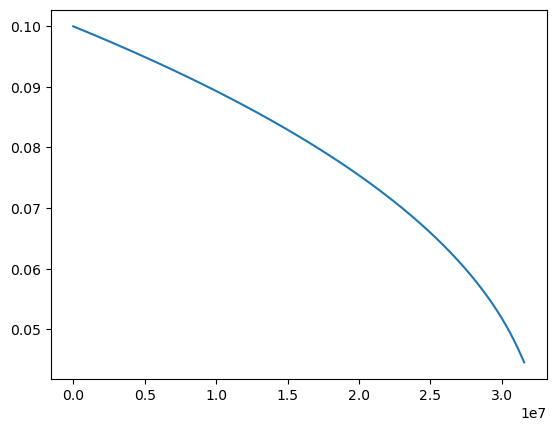

In [46]:
trajectory = traj(M,mu,a,p0,e0,Y0,Sigma0,SigmaPower,h0,Phi_phi0=0.,Phi_theta0=0.,Phi_r0=0.,err=1e-14,max_init_len=int(1e8))
plt.plot(trajectory[0],trajectory[2])

$1-\sigma$: 			 [3.76174155e+01 3.13470189e-03 7.68924281e-04 3.02084450e-04
 1.58844563e-01 2.67889522e-02 2.59089499e-02 5.17647217e+05
 4.41657275e-01 5.34986965e-01 8.10149387e-11 1.56050361e+03
 6.03315247e+01]


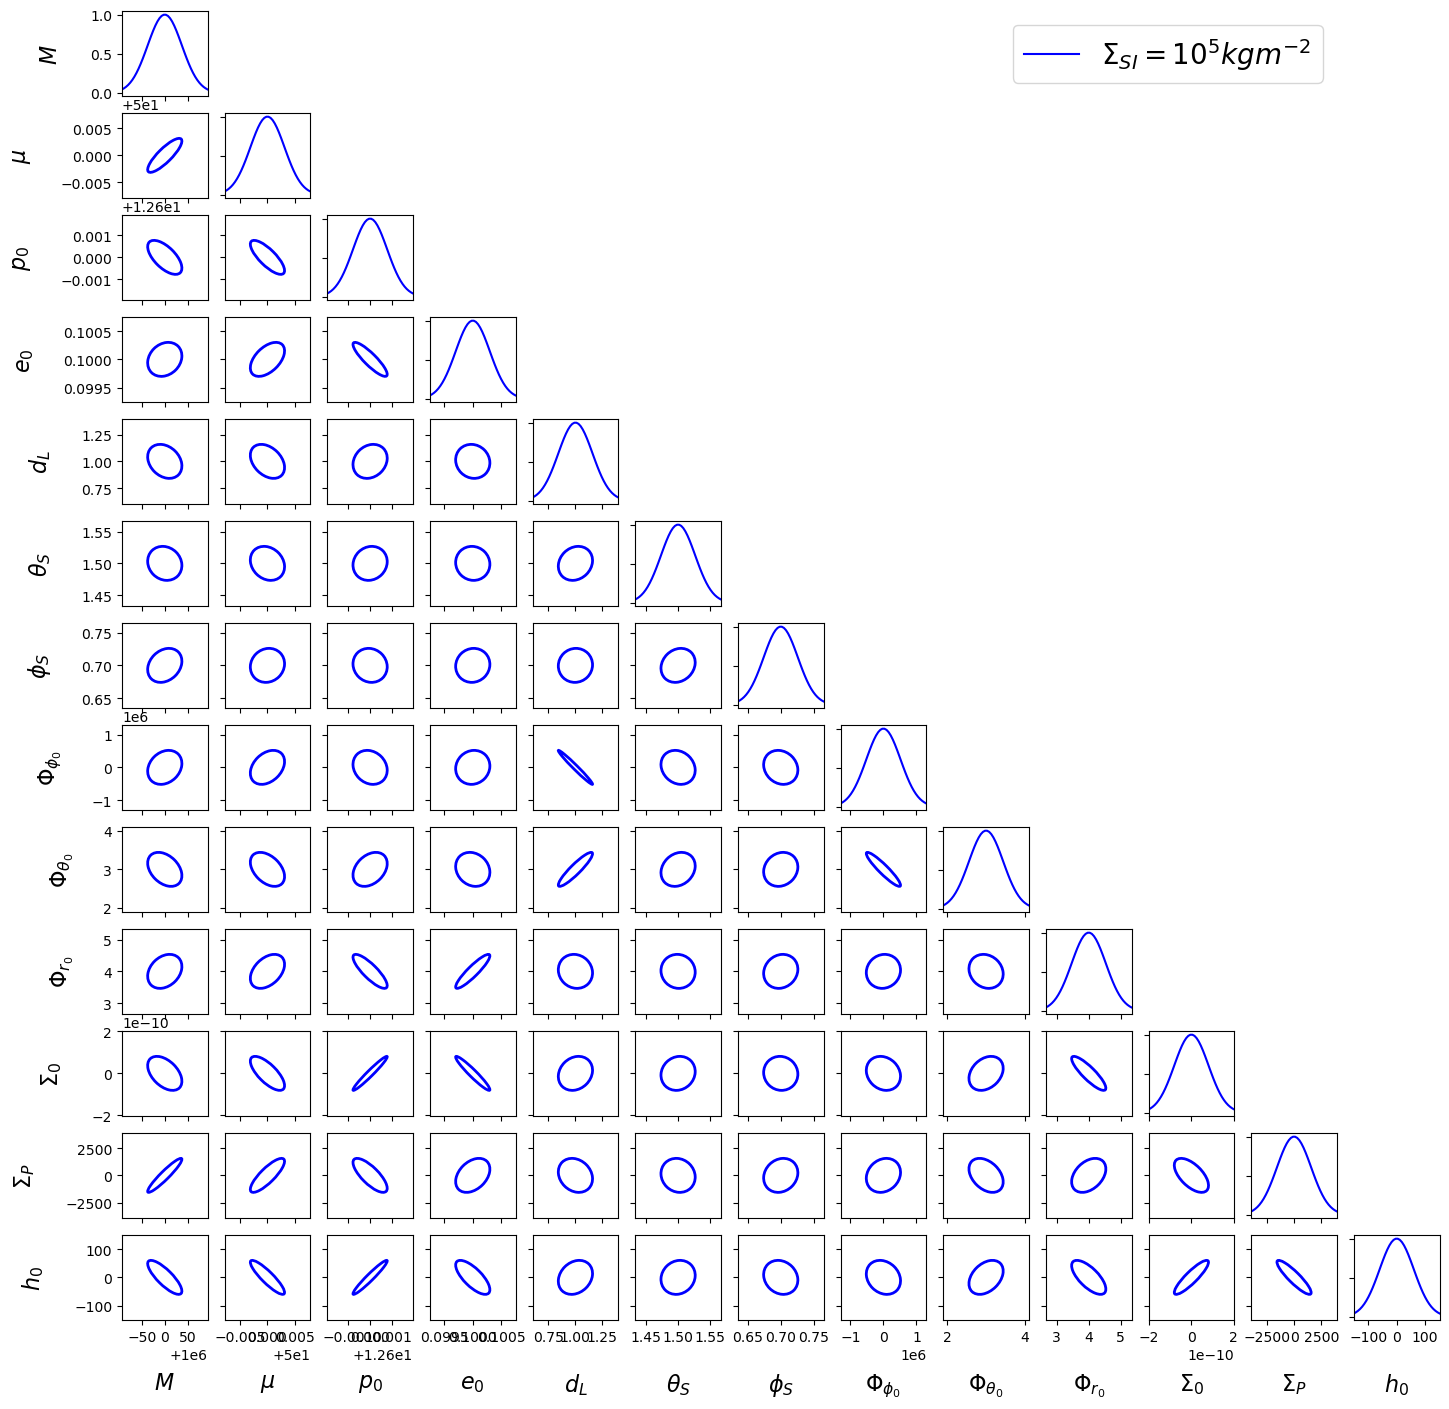

In [41]:
#Plotting

Fisher = np.loadtxt(f'TestRun_SubEcc/Fisher.txt')

#filename = 'pm_subdom_1'

param = {r'$M$':M,\
          r'$\mu$':mu,\
          #r'$a$':a,\
          r'$p_0$':p0,\
          r'$e_0$':e0,\
          #r'$Y_0$':Y0,\
          r'$\Sigma_0$':Sigma0,\
          r'$\Sigma_P$':SigmaPower,\
          r'$h_0$':h0,\
          r'$d_L$':dist,\
          r'$\theta_S$':qS,\
          r'$\phi_S$':phiS,\
          r'$\Phi_{\phi_0}$':Phi_phi0,\
          r'$\Phi_{\theta_0}$':Phi_theta0,\
          r'$\Phi_{r_0}$':Phi_r0,\
          #r'$\theta_K$':qK,\
          #r'$\phi_K$':phiK
        }


param_names = [r'$M$',r'$\mu$',#r'$a$',
               r'$p_0$',r'$e_0$',#r'$Y_0$',
               r'$d_L$',r'$\theta_S$',r'$\phi_S$',
               #r'$\theta_K$',
               #r'$\phi_K$',
               r'$\Phi_{\phi_0}$',r'$\Phi_{\theta_0}$',r'$\Phi_{r_0}$',
               r'$\Sigma_0$',r'$\Sigma_P$',r'$h_0$'
               ]
#paramaters

#######################################
### JOINT
#######################################

covariance = np.linalg.inv(Fisher)
print('$1-\sigma$: \t\t\t', np.sqrt(np.diag(covariance))) 

fig, axs = plt.subplots(len(param_names),len(param_names),figsize=(17,17))

#first param index
for i in range(len(param_names)):
    #second param index
    for j in range(i,len(param_names)):
        
        if i != j:
            cov = np.array(((covariance[i][i],covariance[i][j]),(covariance[j][i],covariance[j][j])))
            #print(cov)
            mean = np.array((param[param_names[i]],param[param_names[j]]))

            cov_ellipse(mean,cov,axs[j,i],lw=2,edgecolor='blue')

            #custom setting the x-y lim for each plot
            axs[j,i].set_xlim([param[param_names[i]]-2.5*np.sqrt(covariance[i][i]), param[param_names[i]]+2.5*np.sqrt(covariance[i][i])])
            axs[j,i].set_ylim([param[param_names[j]]-2.5*np.sqrt(covariance[j][j]), param[param_names[j]]+2.5*np.sqrt(covariance[j][j])])

            axs[j,i].set_xlabel(param_names[i],labelpad=20,fontsize=16)
            axs[j,i].set_ylabel(param_names[j],labelpad=20,fontsize=16)

        else:
            mean = param[param_names[i]]
            var = covariance[i][i]
            
            x = np.linspace(mean-3*np.sqrt(var),mean+3*np.sqrt(var))
            
            axs[j,i].plot(x,normal(mean,var,x),c='blue')
            axs[j,i].set_xlim([param[param_names[i]]-2.5*np.sqrt(covariance[i][i]), param[param_names[i]]+2.5*np.sqrt(covariance[i][i])])
            axs[j,i].set_xlabel(param_names[i],labelpad=20,fontsize=16)
            if i == j and j == 0:
                axs[j,i].set_ylabel(param_names[i],labelpad=20,fontsize=16)
    
    
for ax in fig.get_axes():
    ax.label_outer()
    
for i in range(len(param_names)):
    for j in range(i+1,len(param_names)):
        axs[i,j].axis('off')  # command for hiding the axis.
                
from matplotlib.lines import Line2D

axs[0,len(param_names)-2].legend([Line2D([0],[0],c='b'),
               #Line2D([0],[0],c='r'),
            #Line2D([0],[0],c='g'),
            #Line2D([0],[0],c='k'),
            #Line2D([0],[0],c='y'),
            #Line2D([0],[0],c='b'),
            #Line2D([0],[0],c='y')
                                 ],
           [r'$\Sigma_{SI} = 10^5 kgm^{-2}$',
            #r'($N_\delta = 8, n_{\rm{order}} = 2$) GitHub',
            #r'Extrinsic Sparse err = 5e-12 ($N_\delta = 8, n_{\rm{order}} = 2$) T = 289 sec',
            #r'$N_\delta = 8, n_{\rm{order}} = 4$',
            #r'$N_\delta = 8, n_{\rm{order}} = 2$, T ~ 1353 sec',
            #r'Dynamic Delta ($N_\delta = 8, n_{\rm{order}} = 2$) T ~ 890 sec',
            #r'Extrinsic Sparse ($N_\delta = 8, n_{\rm{order}} = 2$)'

            #'vacuum only'
           ],loc=1,fontsize=20)

plt.savefig('TestRun_SubEcc/Covariance.png',dpi=300,bbox_inches='tight')